<a href="https://colab.research.google.com/github/faranak-jahedi/CryptoDataset/blob/main/PCR_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## County Health Rankings

This data set is intended to demonstrate how various factors affect the health of counties in the United States, as well as highlight the dramatic range in health from county to county. These factors include access to affordable housing, access to well-paying jobs, education opportunities, and many others. This data is provided as a resource to help identify and address injustices and inequities in the health of counties in the United States.

The data set includes statistics on premature death rates, physical health, mental health, low birthweight, adult smoking, and countless others. The data is primarily numeric.

Documentation can be found at : https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2021.pdf


In [ ]:
import pandas as pd
import requests
import io

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from pylab import cm

import matplotlib.pyplot as plt
%matplotlib inline

#### Read in the data

In [ ]:
url = 'http://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2021.csv'
response = requests.get(url)

file_object = io.StringIO(response.content.decode('utf-8'))
df = pd.read_csv(file_object,skiprows=[0])

In [ ]:
df.head()

,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v001_numerator,v001_denominator,...,v057_rawvalue,v057_numerator,v057_denominator,v057_cilow,v057_cihigh,v058_rawvalue,v058_numerator,v058_denominator,v058_cilow,v058_cihigh
0,0,0,0,US,United States,2021,NaN,6906.641094,3854074.0,915437195.0,...,0.507502,166582199,328239523,NaN,NaN,0.192690,NaN,NaN,NaN,NaN
1,1,0,1000,AL,Alabama,2021,NaN,9819.887431,82249.0,13651801.0,...,0.516739,2533668,4903185,NaN,NaN,0.409632,1957932.0,4779736.0,NaN,NaN
2,1,1,1001,AL,Autauga County,2021,1.0,7830.053484,787.0,155765.0,...,0.515080,28777,55869,NaN,NaN,0.420022,22921.0,54571.0,NaN,NaN
3,1,3,1003,AL,Baldwin County,2021,1.0,7680.477270,3147.0,600539.0,...,0.515096,114987,223234,NaN,NaN,0.422791,77060.0,182265.0,NaN,NaN
4,1,5,1005,AL,Barbour County,2021,1.0,11476.629416,515.0,69011.0,...,0.470793,11622,24686,NaN,NaN,0.677896,18613.0,27457.0,NaN,NaN


There are USA aggregate data and state aggregate level data, let's focus only on counties

In [ ]:
# Remove rows with 'countycode' equal to 0
df = df[df['countycode']!=0]

There are 16 Maine counties that we will be taking a close look at later on

In [ ]:
# Extract FIPS codes for Maine counties
maine_fipscode = df[(df['state']=='ME')].fipscode
# Define labels for Maine counties
maine_county_labels = [' Andr',' Aroo',' Cumb', ' Fran', ' Hanc',' Kenn', ' Knox', ' Linc', ' Oxfo',
                       ' Peno', ' Pisc', ' Saga', ' Some', ' Waldo', ' Wash', ' York']

There are a lot of columns we do need. In particular the numerator, denominator, confidence interval, ... columns for forming the raw_values are included. We get rid of them

In [ ]:
# select all the columns from CHR with raw values
## these columns contain the major health-related variables
all_cols = df.columns
# Select columns with 'rawvalue' in the column name
col_names = [i for i in all_cols if 'rawvalue' in i]
print ('Number of CHR variables: ',len(col_names))
## We include the fipscode column because we want to get only the maine counties out later on
col_names.insert(0,"fipscode")
df_sub = df[col_names]
# Subset the DataFrame with selected columns and set FIPS codes as the index
df_sub = df_sub.set_index('fipscode')
df_sub.head()

Number of CHR variables:  79


,v001_rawvalue,v002_rawvalue,v036_rawvalue,v042_rawvalue,v037_rawvalue,v009_rawvalue,v011_rawvalue,v133_rawvalue,v070_rawvalue,v132_rawvalue,...,v053_rawvalue,v054_rawvalue,v055_rawvalue,v081_rawvalue,v080_rawvalue,v056_rawvalue,v126_rawvalue,v059_rawvalue,v057_rawvalue,v058_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,7830.053484,0.198392,4.501499,4.850214,0.092018,0.198108,0.330,6.7,0.306,0.691301,...,0.159731,0.198643,0.004761,0.011742,0.001038,0.029909,0.737708,0.008033,0.515080,0.420022
1003,7680.477270,0.164607,3.647978,4.768294,0.082920,0.185133,0.300,7.8,0.247,0.737135,...,0.209780,0.086076,0.007803,0.010661,0.000690,0.047188,0.832073,0.007085,0.515096,0.422791
1005,11476.629416,0.298415,5.569267,5.590494,0.113553,0.255308,0.412,5.5,0.280,0.531668,...,0.196913,0.478287,0.006886,0.004699,0.002106,0.045248,0.455116,0.018907,0.470793,0.677896
1007,12172.562382,0.238533,4.894377,5.271114,0.102210,0.230848,0.374,7.6,0.334,0.162514,...,0.166696,0.210726,0.004599,0.002143,0.001161,0.027820,0.744083,0.003353,0.467313,0.683526
1009,11096.050649,0.219856,4.986622,5.357809,0.074305,0.229550,0.330,7.9,0.333,0.156345,...,0.187009,0.015080,0.006399,0.003199,0.001159,0.096531,0.867707,0.016185,0.507626,0.899515


We get rid of the columns that do not have at least 70% of the rows with values

In [ ]:
#count and find the percentage of null values and concatenat the results
# Create a DataFrame to show the count and percentage of missing values
missing = pd.concat([df_sub.isnull().sum(), 100*df_sub.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
# Sort columns by count of missing values in descending order
smissing = missing.sort_values(by='count', ascending=False)
print(smissing)
good_cols = smissing[smissing['percentage'] < 30].index
good_cols = good_cols.sort_values()
df_good_cols = df_sub[good_cols]
df_good_cols.head()

               count  percentage
v129_rawvalue   1912   60.852960
v015_rawvalue   1842   58.625080
v149_rawvalue   1836   58.434118
v138_rawvalue   1403   44.653087
v158_rawvalue   1321   42.043285
...              ...         ...
v136_rawvalue      0    0.000000
v060_rawvalue      0    0.000000
v145_rawvalue      0    0.000000
v002_rawvalue      0    0.000000
v144_rawvalue      0    0.000000

[79 rows x 2 columns]


,v001_rawvalue,v002_rawvalue,v003_rawvalue,v004_rawvalue,v005_rawvalue,v009_rawvalue,v011_rawvalue,v014_rawvalue,v021_rawvalue,v023_rawvalue,...,v148_rawvalue,v153_rawvalue,v154_rawvalue,v155_rawvalue,v156_rawvalue,v159_rawvalue,v160_rawvalue,v161_rawvalue,v166_rawvalue,v168_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,7830.053484,0.198392,0.130080,0.000468,6650.0,0.198108,0.330,23.764041,0.890000,0.027281,...,16.562431,0.732906,0.133759,0.42,155.095523,3.126968,2.917280,18.483525,0.805674,0.885166
1003,7680.477270,0.164607,0.167534,0.000702,3471.0,0.185133,0.300,26.006904,0.880000,0.027258,...,14.350620,0.752453,0.111740,0.46,133.604842,3.192381,3.037912,19.287661,0.818164,0.908062
1005,11476.629416,0.298415,0.176732,0.000322,5314.0,0.255308,0.412,37.114262,0.820690,0.037952,...,21.211240,0.608989,0.142707,0.39,102.459673,2.389161,2.008629,11.325918,0.605243,0.732131
1007,12172.562382,0.238533,0.134299,0.000536,6690.0,0.230848,0.374,37.786446,0.880000,0.030628,...,20.410337,0.744159,0.087444,0.40,26.588748,2.688775,2.563367,16.955833,0.692062,0.790574
1009,11096.050649,0.219856,0.179347,0.000207,4440.0,0.229550,0.330,31.239778,0.929256,0.026687,...,21.449131,0.787787,0.078048,0.40,43.309562,2.901714,2.781497,20.022098,0.730081,0.804906


I do a demonstration plot that should be helpful for the Assignment 3 work

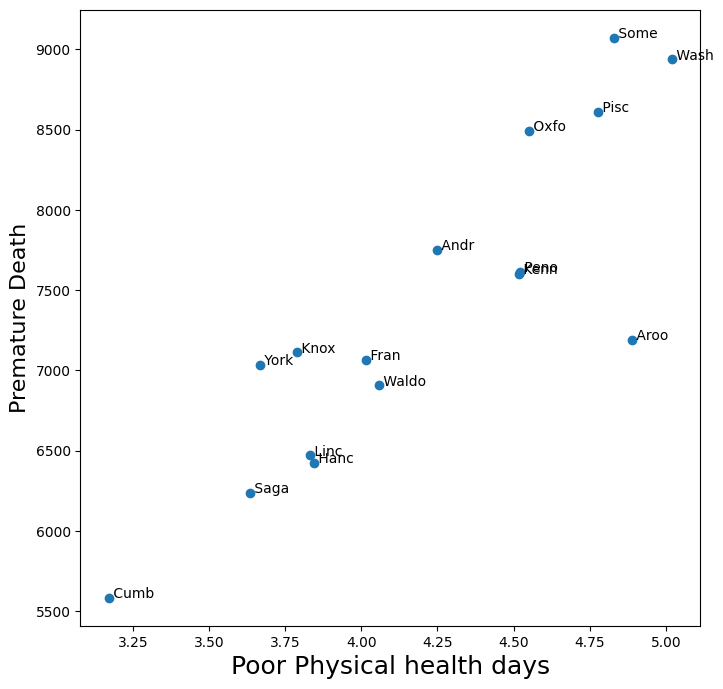

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

# a boolean series gets created with true values for maine counties
maine_counties = df_good_cols.index.isin(maine_fipscode)

x_axis = df_good_cols[maine_counties]['v036_rawvalue']
y_axis = df_good_cols[maine_counties]['v001_rawvalue']
ax.scatter(x_axis, y_axis)

ax.set_xlabel('Poor Physical health days', fontsize=18)
ax.set_ylabel('Premature Death', fontsize=16)

for i, label in enumerate(maine_county_labels):
    plt.annotate(label, (x_axis.iloc[i], y_axis.iloc[i]))

plt.show()

For all columns, fill in missing values with the median and normalize the data by subtracting mean and dividing by the standard deviation

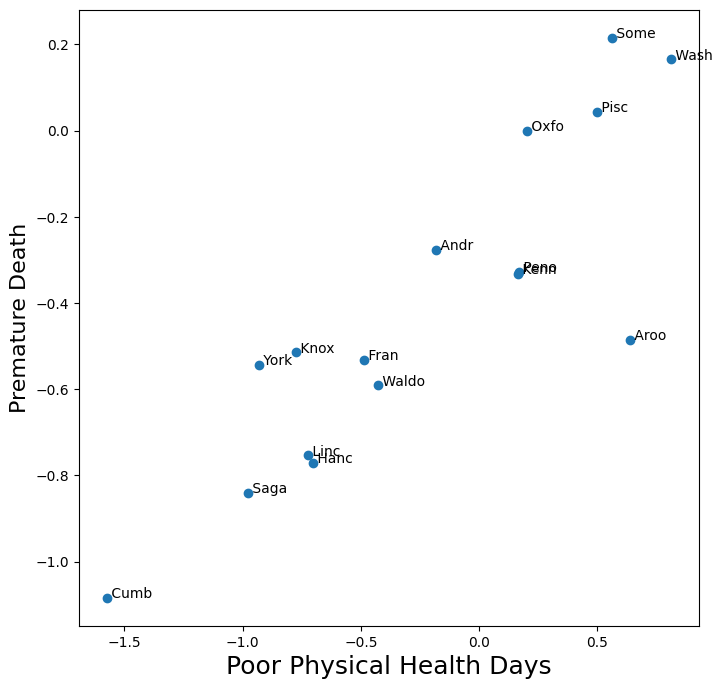

In [ ]:
# Define a threshold for columns with missing values
threshold = 30

# Select columns with missing values less than the threshold
good_cols = smissing[smissing['percentage'] < threshold].index
good_cols = good_cols.sort_values()

# Subset the DataFrame with selected columns
df_good_cols = df_sub[good_cols]

# Fill missing values with the median
df_good_cols = df_good_cols.fillna(df_good_cols.median())

# Normalize the data by subtracting the mean and dividing by the standard deviation
df_good_cols = (df_good_cols - df_good_cols.mean()) / df_good_cols.std()

# Create a scatterplot
fig, ax = plt.subplots(figsize=(8, 8))

# Create a boolean series to filter Maine counties
maine_counties = df_good_cols.index.isin(maine_fipscode)

x_axis = df_good_cols[maine_counties]['v036_rawvalue']
y_axis = df_good_cols[maine_counties]['v001_rawvalue']

ax.scatter(x_axis, y_axis)

ax.set_xlabel('Poor Physical Health Days', fontsize=18)
ax.set_ylabel('Premature Death', fontsize=16)

# Annotate points with county labels
for i, label in enumerate(maine_county_labels):
    plt.annotate(label, (x_axis.iloc[i], y_axis.iloc[i]))

plt.show()

Run KMEANS with 5 clusters on the data

In [ ]:
from sklearn.cluster import KMeans

# Initialize K-Means with the desired number of clusters (5)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit K-Means to the data (assuming maine_pca_components contains your data)
y_pred = kmeans.fit_predict(df_good_cols)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Print out the clusters that each Maine county landed in. Observations ?

In [ ]:
# Print the cluster assignments for each Maine county
for i, label in enumerate(maine_county_labels):
    print(f"County: {label}, Cluster: {y_pred[i]}")


County:  Andr, Cluster: 1
County:  Aroo, Cluster: 0
County:  Cumb, Cluster: 2
County:  Fran, Cluster: 1
County:  Hanc, Cluster: 1
County:  Kenn, Cluster: 2
County:  Knox, Cluster: 2
County:  Linc, Cluster: 1
County:  Oxfo, Cluster: 2
County:  Peno, Cluster: 1
County:  Pisc, Cluster: 1
County:  Saga, Cluster: 2
County:  Some, Cluster: 2
County:  Waldo, Cluster: 1
County:  Wash, Cluster: 1
County:  York, Cluster: 1


# Observations:
 - Each Maine county is assigned to one of the five clusters.
 - The cluster assignments provide information about the similarity or dissimilarity of counties based on the selected features.
 - Counties within the same cluster share common characteristics in terms of the analyzed data.
 - Counties in different clusters have distinct attribute profiles.
 - None of these counties are in the cluster 0 or 1.

Produce a few 2D graphs that plot two attribute values (ie v001, v036 : premature death, poor physical days) for Maine counties and color the counties to distinguish the group.

<ipython-input-57-e11403674d90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attributes_with_clusters['Cluster'] = y_pred  # Add cluster assignments


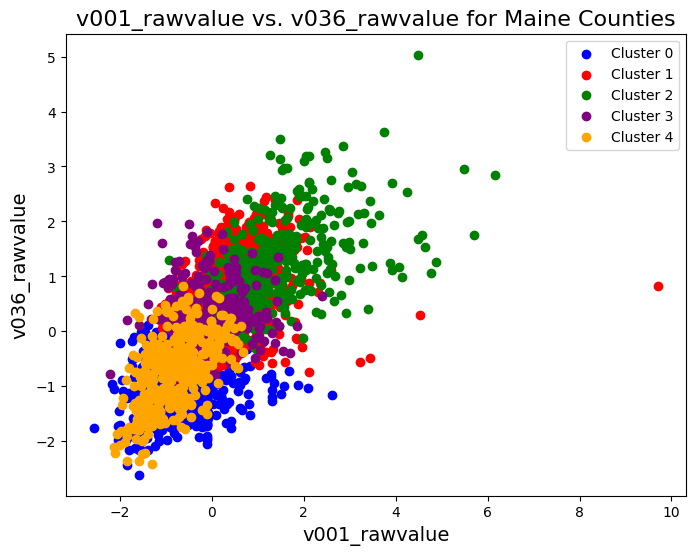

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame containing the selected attributes and cluster assignments
selected_attributes = ['v001_rawvalue', 'v036_rawvalue']
attributes_with_clusters = df_good_cols[selected_attributes]
attributes_with_clusters['Cluster'] = y_pred  # Add cluster assignments

# Define colors for each cluster
cluster_colors = ['blue', 'red', 'green', 'purple', 'orange']

# Create a scatterplot for each pair of attributes
for i in range(len(selected_attributes)):
    for j in range(i + 1, len(selected_attributes)):
        attribute_x = selected_attributes[i]
        attribute_y = selected_attributes[j]

        plt.figure(figsize=(8, 6))
        for cluster in range(n_clusters):
            cluster_data = attributes_with_clusters[attributes_with_clusters['Cluster'] == cluster]
            plt.scatter(cluster_data[attribute_x], cluster_data[attribute_y], label=f'Cluster {cluster}', color=cluster_colors[cluster])

        plt.xlabel(attribute_x, fontsize=14)
        plt.ylabel(attribute_y, fontsize=14)
        plt.title(f'{attribute_x} vs. {attribute_y} for Maine Counties', fontsize=16)
        plt.legend()
        plt.show()


<ipython-input-58-751ff886adef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attributes_with_clusters['Cluster'] = y_pred  # Add cluster assignments


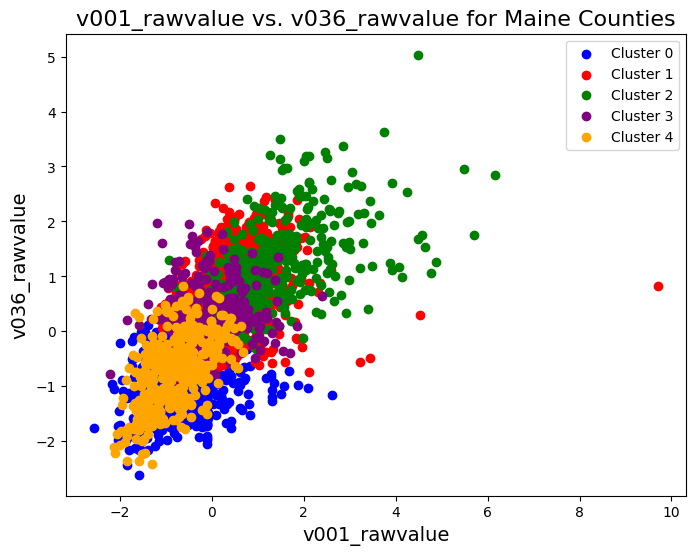

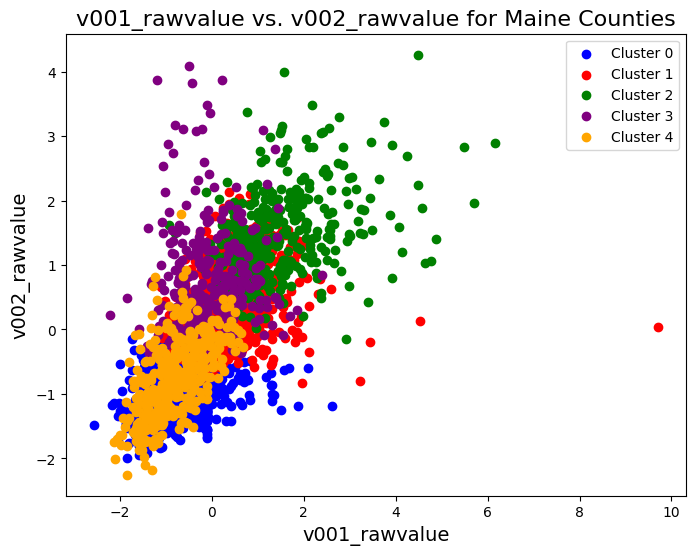

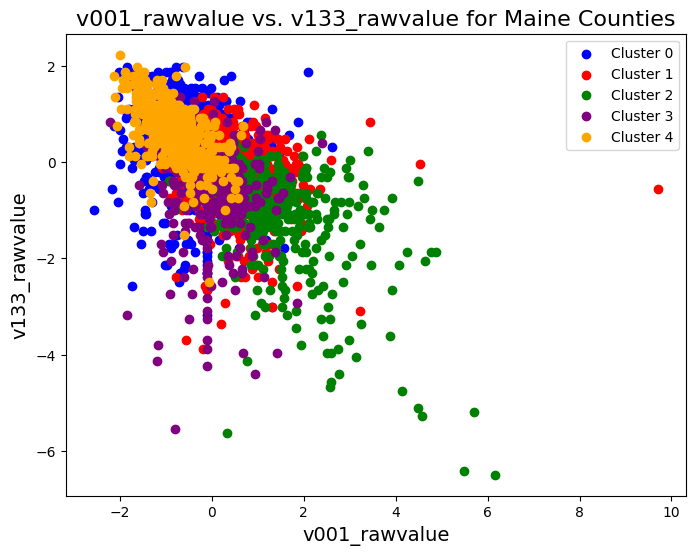

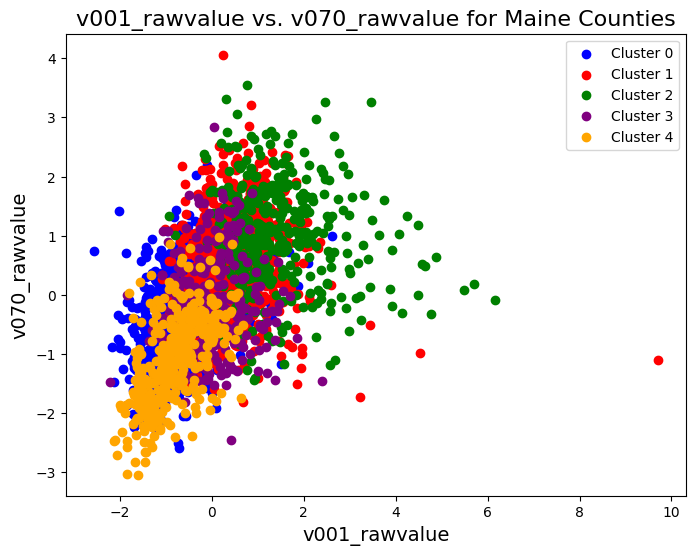

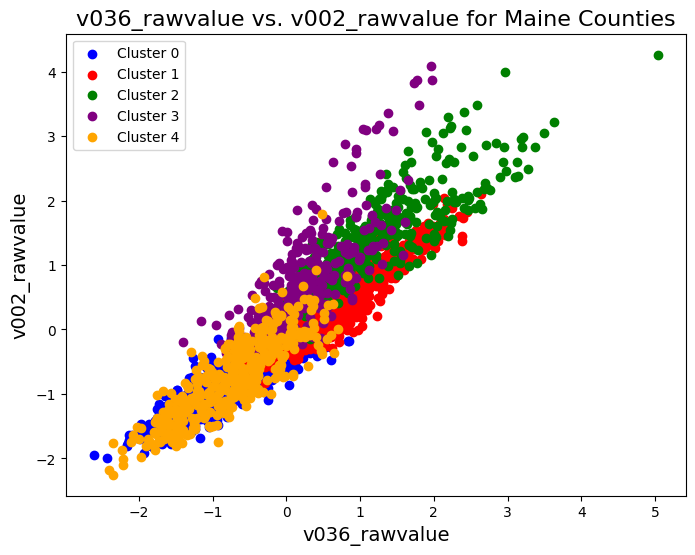

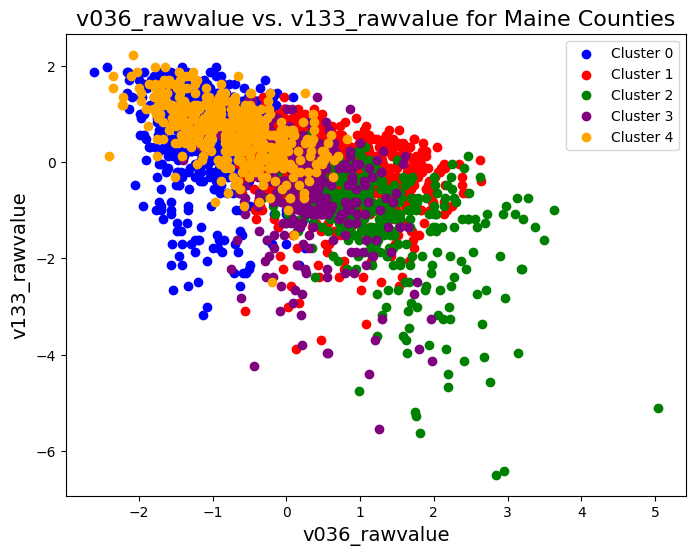

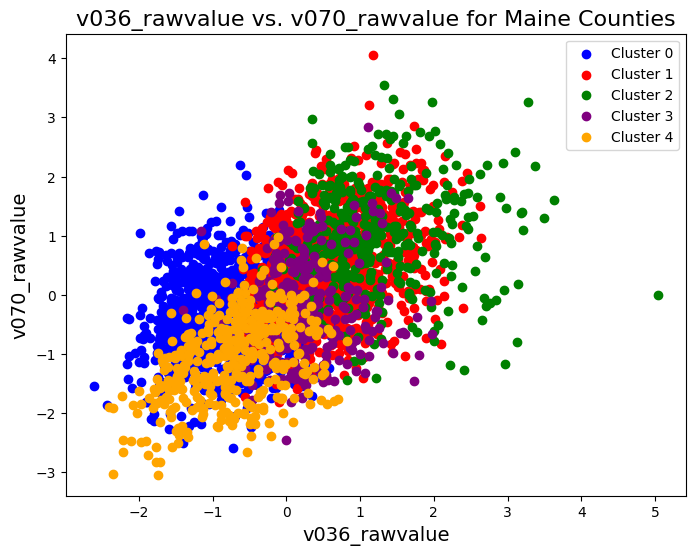

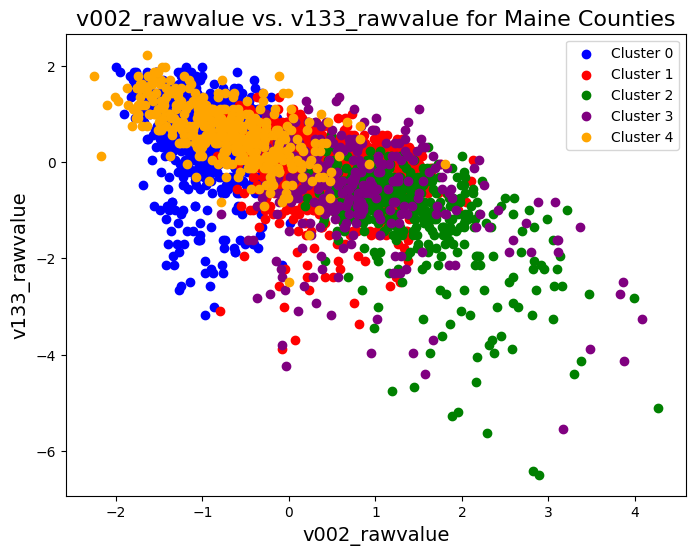

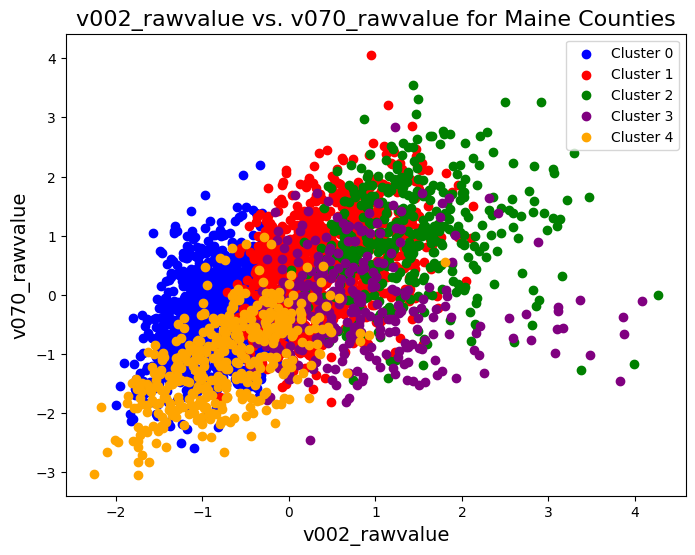

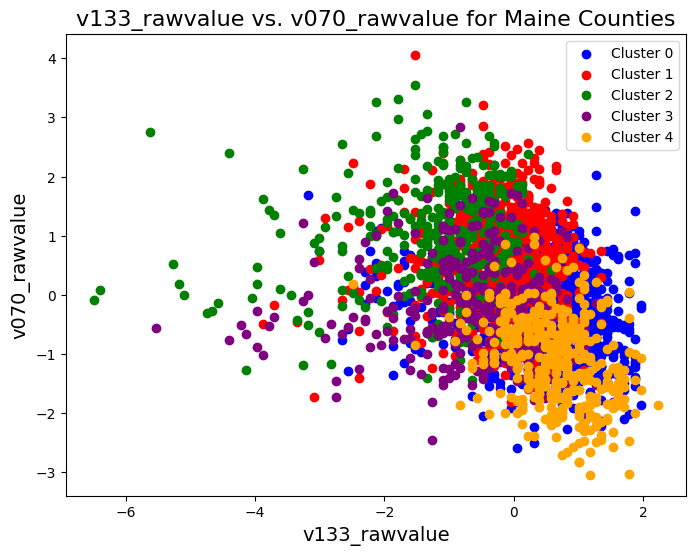

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame containing the selected attributes and cluster assignments
selected_attributes = ['v001_rawvalue', 'v036_rawvalue', 'v002_rawvalue', 'v133_rawvalue', 'v070_rawvalue']
attributes_with_clusters = df_good_cols[selected_attributes]
attributes_with_clusters['Cluster'] = y_pred  # Add cluster assignments

# Define colors for each cluster
cluster_colors = ['blue', 'red', 'green', 'purple', 'orange']

# Create a scatterplot for each pair of attributes
for i in range(len(selected_attributes)):
    for j in range(i + 1, len(selected_attributes)):
        attribute_x = selected_attributes[i]
        attribute_y = selected_attributes[j]

        plt.figure(figsize=(8, 6))
        for cluster in range(n_clusters):
            cluster_data = attributes_with_clusters[attributes_with_clusters['Cluster'] == cluster]
            plt.scatter(cluster_data[attribute_x], cluster_data[attribute_y], label=f'Cluster {cluster}', color=cluster_colors[cluster])

        plt.xlabel(attribute_x, fontsize=14)
        plt.ylabel(attribute_y, fontsize=14)
        plt.title(f'{attribute_x} vs. {attribute_y} for Maine Counties', fontsize=16)
        plt.legend()
        plt.show()


Run KMeans for a different number of clusters and plot the within cluster sum of squares (WCCS) (y-axis) as function of the number of clusters (x-axis).  Was 5 a good choice for the number of clusters ?

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

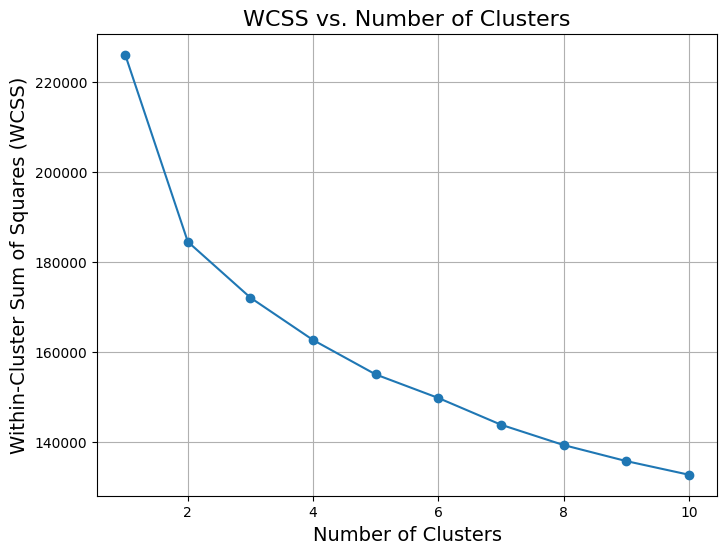

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize a list to store the WCSS values
wcss = []

# Define a range of cluster numbers to test
cluster_range = range(1, 11)

# Run K-Means for each cluster number and calculate WCSS
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_good_cols)
    wcss.append(kmeans.inertia_)

# Plot WCSS as a function of the number of clusters
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
plt.title('WCSS vs. Number of Clusters', fontsize=16)
plt.grid(True)

plt.show()


The "elbow" in the plot occurs at 2 clusters, so there might be a diminishing return in reducing the within-cluster sum of squares (WCSS) beyond two clusters.

- Two clusters is a better choice compared to five clusters based on the "elbow" point. It provides a reasonably good way to separate the data with reduced within-cluster variance, possibly capturing the main differences or patterns present in the dataset.

- A significant decrease in the WCSS up to two clusters indicates that adding more clusters does not explain much more variance within the data, the data might not have distinct, well-separated clusters beyond that point.